# Age Classification of *Chen Pi* with ResNet50

Images are taken manually.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image
import torchvision.transforms as transforms
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os

In [2]:
IMG_DIR = "./data_orange_peels/"
TRAIN_PROPORTION = 0.8
BATCH_SIZE = 32
NUM_EPOCHS = 40
IMAGE_SIZE = (256, 256)
LR = 0.001
RESNET_MEAN = [0.485, 0.456, 0.406]
RESNET_STD = [0.229, 0.224, 0.225]

In [3]:
encoder = {
    6 : 0,
    10 : 1,
    15 : 2,
    20 : 3,
}

decoder = { v:k for k,v in encoder.items()}

class OrangePeelsDataset(Dataset):
    def __init__(self, img_dir, transform = None, target_transform = None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        # store paths and labels in DataFrame
        data = { "image_path" : [], "label" : [] }
        for sub_dir in os.listdir(img_dir):
            for file in os.listdir(os.path.join(img_dir, sub_dir)):
                if file.startswith("IMG"):
                    data["image_path"].append(os.path.join(img_dir, sub_dir, file))
                    data["label"].append(int(sub_dir))

        self.annotations = pd.DataFrame(data).sample(frac = 1).reset_index(drop = True)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        image = read_image(self.annotations.iloc[idx, 0]).float()
        label = encoder[self.annotations.iloc[idx, 1]]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [4]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.Normalize(mean = RESNET_MEAN, std = RESNET_STD)
])

inverse_transform = transforms.Compose([
    transforms.Normalize(mean = [0., 0., 0.,], std = [1/sd for sd in RESNET_STD]),
    transforms.Normalize(mean = [-m for m in RESNET_MEAN], std = [1., 1., 1.]),
])

data = OrangePeelsDataset(IMG_DIR, transform = transform)

train, test = random_split(
    data,
    [
        int(0.8*len(data)),
        len(data) - int(0.8*len(data))
    ]
)

train_loader = DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test, batch_size = BATCH_SIZE, shuffle = True)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Text(0.5, 1.0, 'Label: 0')

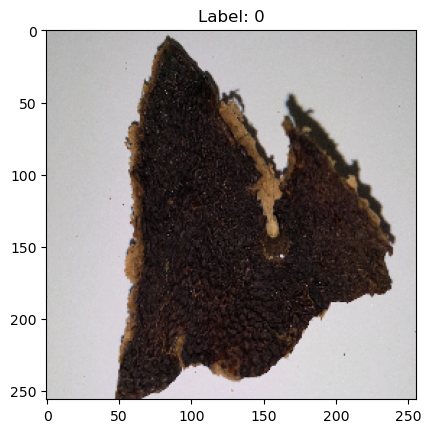

In [6]:
image = inverse_transform(data[random.randint(0, len(data))][0]).numpy().astype(np.int32).transpose(1, 2, 0)
plt.imshow(image)
plt.title(f"Label: {data[0][1]}")

In [7]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained = True)
feature_extractor = nn.Sequential(*list(model.children())[:-1])
print("Shape of feature extractor portion:", feature_extractor(torch.rand(1, 3, IMAGE_SIZE[0], IMAGE_SIZE[1])).shape)

Using cache found in C:\Users\fongc/.cache\torch\hub\pytorch_vision_v0.6.0
c:\Users\fongc\anaconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\fongc\anaconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Shape of feature extractor portion: torch.Size([1, 2048, 1, 1])


In [8]:
model = nn.Sequential(
    feature_extractor,
    nn.Flatten(),
    nn.Linear(2048, 4), # 4 classes
).to(device)

# define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [9]:
losses = []
for e in range(NUM_EPOCHS):
    # training
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        # move to device
        images = images.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward pass
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # print statistics
        if i % 8 == 0:
            print("[{}, {}] Loss: {}".format(e + 1, i, loss.item()))

[1, 0] Loss: 1.341435194015503
[1, 8] Loss: 1.052897572517395
[2, 0] Loss: 0.823013961315155
[2, 8] Loss: 0.5164265632629395
[3, 0] Loss: 0.517554759979248
[3, 8] Loss: 0.6240706443786621
[4, 0] Loss: 0.40307796001434326
[4, 8] Loss: 0.41545987129211426
[5, 0] Loss: 0.35380446910858154
[5, 8] Loss: 0.7267059683799744
[6, 0] Loss: 0.20823389291763306
[6, 8] Loss: 0.3306500315666199
[7, 0] Loss: 0.17707307636737823
[7, 8] Loss: 0.1328270137310028
[8, 0] Loss: 0.16203685104846954
[8, 8] Loss: 0.1603512316942215
[9, 0] Loss: 0.05673137679696083
[9, 8] Loss: 0.07541880756616592
[10, 0] Loss: 0.03668705374002457
[10, 8] Loss: 0.009363140910863876
[11, 0] Loss: 0.022810805588960648
[11, 8] Loss: 0.05187169462442398
[12, 0] Loss: 0.21142002940177917
[12, 8] Loss: 0.043543267995119095
[13, 0] Loss: 0.035690709948539734
[13, 8] Loss: 0.013855301775038242
[14, 0] Loss: 0.2732604742050171
[14, 8] Loss: 0.5764535665512085
[15, 0] Loss: 0.025462143123149872
[15, 8] Loss: 0.13419930636882782
[16, 0] 

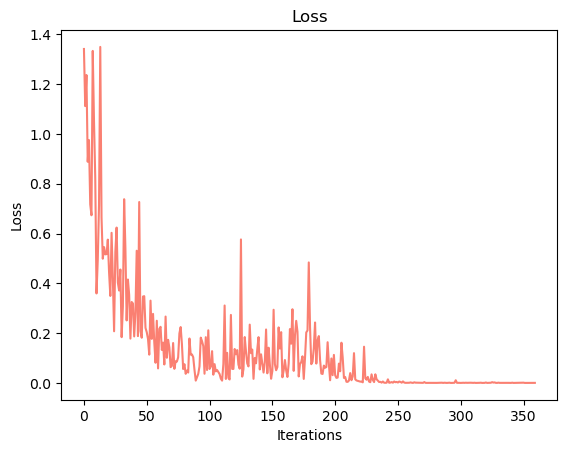

In [10]:
plt.plot(losses, c="salmon")
plt.title("Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

In [11]:
predictions = torch.tensor([], dtype = torch.long).to(device)
true = torch.tensor([], dtype = torch.long).to(device)

correct = 0
total = 0
model.eval()
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predictions = torch.cat((predictions, predicted))
        true = torch.cat((true, labels))

Accuracy: 0.8


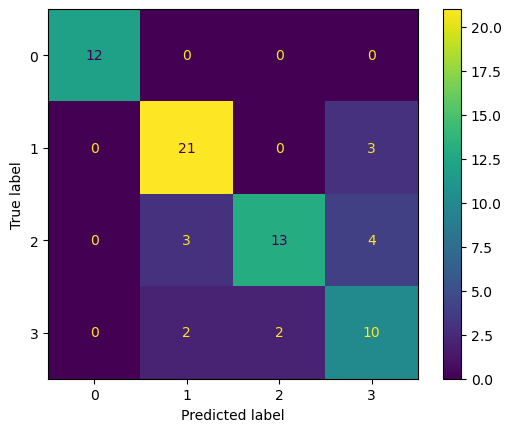

In [12]:
matrix = metrics.ConfusionMatrixDisplay.from_predictions(true.cpu().numpy(), predictions.cpu().numpy())
print("Accuracy:", metrics.accuracy_score(true.cpu().numpy(), predictions.cpu().numpy()))

In [15]:
print("Unique labels:", true.unique())
auc_scores = []
for i in range(4):
    label_trues = true.cpu().numpy() == i
    label_predicts = predictions.cpu().numpy() == i

    auc_score = metrics.roc_auc_score(label_trues, label_predicts)
    print("\tAUC for label {} ({}): {}".format(
        decoder[i], i,
        auc_score
    ))
    auc_scores.append(auc_score)

print("Average AUC:", np.mean(auc_scores))

Unique labels: tensor([0, 1, 2, 3], device='cuda:0')
	AUC for label 6 (0): 1.0
	AUC for label 10 (1): 0.8831521739130435
	AUC for label 15 (2): 0.8049999999999999
	AUC for label 20 (3): 0.7946428571428571
Average AUC: 0.8706987577639752


Image Number: 11


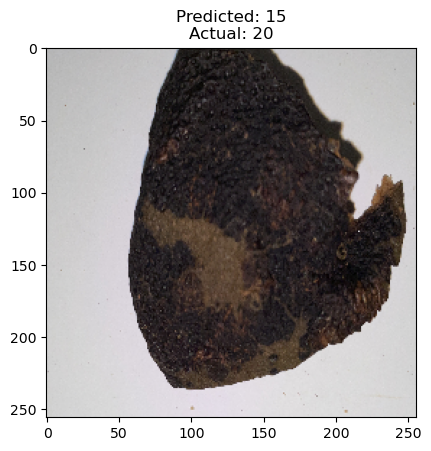

In [38]:
idx = np.random.randint(0, len(test))
sample_image = test[idx][0]
sample_label = test[idx][1]
print("Image Number:", idx)

with torch.no_grad():
    sample_predict = model(sample_image[None, :, :, :].to(device))
    _, sample_predict = torch.max(sample_predict.data, 1)

plt.imshow(inverse_transform(sample_image).numpy().astype(np.int32).transpose(1, 2, 0))
plt.title("Predicted: {}\nActual: {}".format(decoder[sample_predict.item()], decoder[sample_label]))
plt.show()